In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import gymnasium as gym
from gymnasium import spaces
import stable_baselines3 as sb

# from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
# from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_checker import check_env

In [25]:
def RK4(fun, x, dt, t = 0, a = 0):

    k1 = fun(t,      x,         a)
    k2 = fun(t+dt/2, x+dt*k1/2, a)
    k3 = fun(t+dt/2, x+dt*k2/2, a)
    k4 = fun(t+dt,   x+dt*k3,   a)

    y = x + dt/6*(k1+2*k2+2*k3+k4)
    return y

# Todo esto deberia ir dentro del Env eventualmente

gamma     = .1
gammath   = .1
L     = .2
G     = .98

def cart_evol(t, x, a = 0):
    vDot = a - gamma * x[1]
    xDot = x[1]
    return np.array([xDot, vDot])

def pend_evol(t, x, a = 0):
    thDotDot = (a * np.cos(x[0]) - G * np.sin(x[0]))/L - gammath * x[1]
    thDot    = x[1]
    return np.array([thDot, thDotDot])

def get_pos_pend(ang, x, L):
    return x - L*np.sin(ang), L*np.cos(ang)

def observations(x,th,xDot,thDot):
    return np.array([x, np.cos(th), np.sin(th), xDot/2, thDot/20]).astype(np.float32)

#-------------------------

class Pendulo(gym.Env):
    """
    Custom Environment that follows gym interface.
    This is a simple env where the agent must learn to go always left. 
    """
    # Because of google colab, we cannot implement the GUI ('human' render mode)
    metadata = {'render.modes': ['data']}
    # Define constants for clearer code
    # Distancias en mm?

    def __init__(self, fps = 120, target_th = 1, max_steps = 2000, render_mode = 'data'):
        super(Pendulo, self).__init__()

        # Size of the 1D-grid
        self.rail_lengh = 1

        # (x,th), (xDot,thDot)
        self.agent_vars = np.array(((0.,np.pi+np.random.normal(0,.1)),(0.,0.)))

        # variables de tiempo
        self.n_step = 0
        self.max_steps = max_steps
        self.dt      = 1/fps # timestep en seg

        # threshold del reward
        self.targetH = np.cos(target_th)

        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions, we have 3: left, right and still
        self.n_actions = 3
        self.action_space = spaces.Discrete(self.n_actions)
        # The observation will be the coordinate of the agent
        # (x, v, cos th, sin th, thDot)
        # elijo pasarle seno y coseno enves del angulo xq quedan en [-1,1]
        # y no tienen el problema de discontinuidad de th en [-pi,pi]
        self.observation_space = spaces.Box(low = -1, high = 1,
                                            shape=(5,), dtype=np.float32)
        
        self.render_mode = render_mode
        with open("output.txt", "w") as f:
            f.write("x\tcos(th)\tsin(th)\tv\tthDot\t\n")

    def reset(self, seed = None,):
        """
        Important: the observation must be a numpy array
        :return: (np.array) 
        """
        super().reset(seed=seed)
        # with open("output.txt", "w") as f:
        #     f.write("x\tcos(th)\tsin(th)\tv\tthDot\t\n")
        # Initialize the agent at the right of the grid
        self.agent_vars = np.array(((0.,np.pi+np.random.normal(0,.1)),(0.,0.)))
        # here we convert to float32 to make it more general (in case we want to use continuous actions)
        return observations(*np.ravel(self.agent_vars)), {}

    def step(self, action):

        x,th = self.agent_vars[0]
        v,thDot = self.agent_vars[1]

        if action > self.n_actions:
            raise ValueError("Received invalid action={} which is not part of the action space".format(action))
        elif abs(x) > 1:
            # x = np.clip(x, -1, 1)
            # a = -v/self.dt * .2
            # thDotDot = -v/self.dt * 1.2
            # v = 0
            return observations(*np.ravel(self.agent_vars)),\
                -10, True, False, {"Crashed" : True}
        else:
            thDotDot = a = action - 1

        x, v = RK4(cart_evol, [x, v], self.dt, a = a)
        th, thDot = RK4(pend_evol, [th, thDot], self.dt, a = thDotDot)

        # print(x,v,th,thDot)

        self.agent_vars = np.array(((x,th),(v,thDot)))
        
        if self.n_step >= 1500:
            truncated = True
        else: truncated = False
        # Null reward everywhere except when reaching the goal (left of the grid)
        # reward = 1 if np.cos(th) < self.targetH else -1
        reward = -np.cos(th)/(1+3*abs(x))
        # Optionally we can pass additional info, we are not using that for now
        info = {}

        return observations(*np.ravel(self.agent_vars)),\
                reward, False, truncated, info

    def render(self):
        if self.render_mode == 'data':
            # agent is represented as a cross, rest as a dot
            data = observations(*np.ravel(self.agent_vars))
            with open("output.txt", "a") as f:
                for var in data:
                    f.write(str(var))
                    f.write("\t")
                f.write("\n")
        else:
            raise NotImplementedError()

    def close(self):
        pass

In [26]:
env = Pendulo()
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

In [27]:
gym.register(
    id="Pendulo",
    entry_point=Pendulo,
)
# wrap it
single_env = Pendulo(render_mode = "data", target_th = 2.5)
multi_env = make_vec_env(Pendulo , n_envs = 2)

model = sb.PPO('MlpPolicy', env)

c:\ProgramData\anaconda3\envs\Inv1\Lib\site-packages\gymnasium\envs\registration.py:693: UserWarning: WARN: Overriding environment Pendulo already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [57]:
model.learn(500000)

In [ ]:
save_dir = "/tmp/gym/"
model.save(save_dir + "/Pendulum_PPO_5E6Iterations_2envs")

In [58]:
# Test the trained agent
obs, _ = single_env.reset()

n_steps = 1000
for step in range(n_steps):
  action, _ = model.predict(obs, deterministic=True)
  obs, reward, terminated, truncated, info = single_env.step(action)
  single_env.render()
  #print("Step {}".format(step + 1), "\t", "Action: ", action, "\t", "reward=", reward)
  if terminated or truncated:
    # Note that the VecEnv resets automatically
    # when a done signal is encountered
    print(step+1, info)
    break

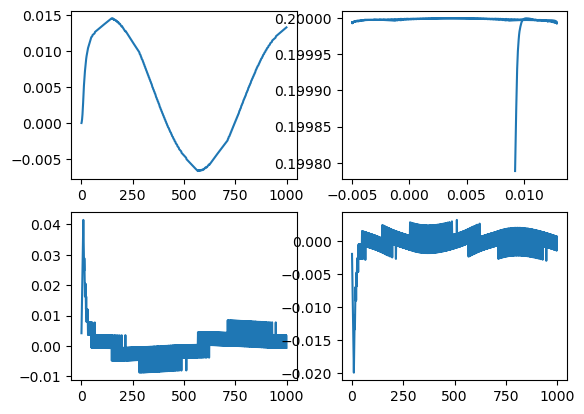

In [59]:
data = pd.read_table("output.txt")
x, costh, sinth, v, thDot = data["x"],data["cos(th)"],data["sin(th)"],data["v"],data["thDot"],

fig, ax = plt.subplots(2,2)

ax[0,0].plot(x)
ax[0,1].plot(x - .2*sinth, - .2*costh)
ax[1,0].plot(v)
ax[1,1].plot(thDot)

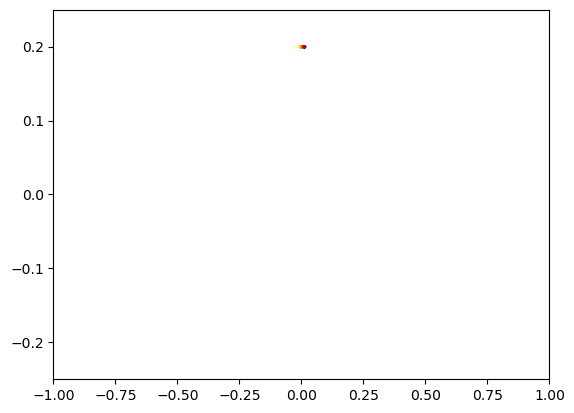

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.collections as mcoll
import matplotlib.path as mpath
from cycler import cycler

xx = x - .2*sinth
yy = - .2*costh

MAP = 'jet'
NPOINTS = len(xx)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set(xlim = (-1,1), ylim = (-.25,.25))
cm = plt.get_cmap(MAP)
for i in range(10):
    colors = [cm(1.0*i/(NPOINTS-1)) for i in range(NPOINTS-1)]
    ax1.set_prop_cycle(cycler('color', colors))
    for i in range(NPOINTS-1):
        plt.plot(xx[i:i+2],yy[i:i+2])

# plt.title('Inner minimization', fontsize=25)
# plt.xlabel(r'Friction torque $[Nm]$', fontsize=25)
# plt.ylabel(r'Accelerations energy $[\frac{Nm}{s^2}]$', fontsize=25)
plt.show() # Show the figure

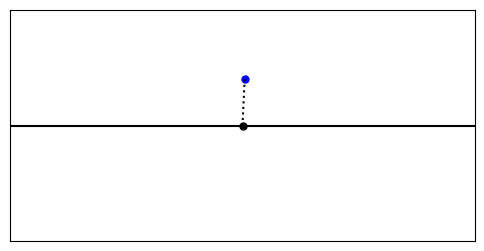

In [61]:
from matplotlib import animation

fig, ax = plt.subplots(figsize = (6,3), dpi = 100)

x1 = x
zz = np.zeros(len(x))
xx = x - .2*sinth
yy = - .2*costh

# x1 = np.array(x1[::10])
# zz = np.array(zz[::10])
# xx = np.array(xx[::10])
# yy = np.array(yy[::10])

rail = ax.plot([-1,1],[0,0], "k")[0]
line = ax.plot([xx[0],x[0]],[yy[0],zz[0]], "k:")[0]

scat = ax.scatter(xx[0], yy[0], c="b", s=25)
scat2 = ax.scatter(x[0], zz[0], c="k", s=25)

ax.set(xlim=[-1, 1], ylim=[-.5, .5], xticks=[], yticks=[])


def update(frame):
    # for each frame, update the data stored on each artist.
    x = x1[frame]
    z = zz[frame]
    X = xx[frame]
    Y = yy[frame]
    # update the scatter plot:
    data = np.stack([X, Y]).T
    data2 = np.stack([x, z]).T
    scat.set_offsets(data)
    scat2.set_offsets(data2)
    # update the line plot:
    line.set_xdata([x,X])
    line.set_ydata([z,Y])
    return (line, scat)


ani = animation.FuncAnimation(fig=fig, func=update, frames = len(x1))
ani.save("mov.mp4", fps = 120)